<h1><center>Identificación de Retinopatía Diabética mediante redes neuronales convolucionales con el uso de fotografías de fondo de ojos

<center>Kin Nevárez<center>
    
<center>24 de julio 2022<center>

<center>Facultad de Ciencias Físico Matemáticas<center>

<center>Maestría en Ciencia de Datos<center>

Se realiza un modelo de aprendizaje de máquina, en específico redes neuronales convolucionales (CNN), para identificar si un paciente tiene la enfermedad de retinopatía diabética con el uso de fotografías de fondo de ojo. Se utilizaron distintos métodos de transferencia de entrenamiento y un modelo propio para comparar resultados y encontrar el modelo que se ajuste mejor a los datos reales. Los resultados indican que la red neuronal propia se desempeña mejor que los modelos de transferencia al momento de detectar la enfermedad de ojo, obteniendo una exactitud en el conjunto de entrenamiento y validación de 98% y 95%, respectivamente; así como una exactitud final de 96% en el conjunto de prueba.


### 1. Establecimiento del espacio de trabajo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/MAESTRÍA/TETRAMESTRE 4/PROCESAMIENTO Y CLASIFICACIÓN/Proyecto Final v3')
#https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

La Retinopatía Diabética (RD) es una complicación común de la diabetes mellitus, que provoca lesiones en la retina que afectan a la visión y si no se detecta a tiempo, puede provocar ceguera. (Wejdan et al., 2020) En la mayoría de los pacientes, la retinopatía se desarrolla de 10 a 15 años después del diagnóstico de la diabetes. Con  el  incremento  de  la  prevalencia  de  la  diabetes  más  personas  están  en  riesgo  de  sufrir retinopatía. 

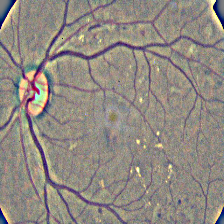

In [3]:
from PIL import Image
with Image.open('DR_dataset/1dbdc32c17db.png').resize((224,224)) as img:
  img.load()
img

Para dar paso a la metodología seleccionada, se utilizó una muestra del conjunto de datos de (Kaggle, 2019, APTOS), que contiene 3,662 imágenes, puesto que entrenar con el conjunto de datos completo requiere una capacidad computacional muy grande y de momento no se cuentan con los recursos necesarios. Las imágenes consisten en escaneos de retina (fotografías de fondo de ojos) de áreas rurales de la India para detectar la RD. Están divididas en 5 clases: 

0: No RD

1: Leve

2: Moderado

3: Severo

4: Proliferativo



### 2. Obtención de los datos

In [4]:
import pandas as pd
images_data = pd.read_csv('DR_data.csv')
images_data.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
images_data.value_counts(['diagnosis'])

diagnosis
0            1805
2             999
1             370
4             295
3             193
dtype: int64

In [6]:
import numpy as np
images_data['labels']=np.where(images_data['diagnosis']==0,0,1)
images_data.value_counts(['labels'])

labels
1         1857
0         1805
dtype: int64

In [7]:
import glob
import tensorflow as tf

images = glob.glob('DR_dataset/*.*')

data = []
labels = []
n = len(images_data['id_code'])
for i in range(0,n):   
    id_code = images_data['id_code'][i]
    img_label = images_data['labels'][i]
    image=np.array(tf.keras.preprocessing.image.load_img('DR_dataset/'+id_code+'.png', color_mode='rgb',target_size=(224,224)))
    data.append(image)
    labels.append(img_label)

In [8]:
images = np.array(data)
labels = np.array(labels)

In [9]:
images.shape

(3662, 224, 224, 3)

In [10]:
labels.shape

(3662,)

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

lb = LabelEncoder()
y = np_utils.to_categorical(lb.fit_transform(labels))

In [12]:
y.shape

(3662, 2)

### 3. Entrenamiento del modelo

In [13]:
from sklearn.model_selection import train_test_split

train_x, rem_x, train_y, rem_y = train_test_split(images,y, train_size=0.7,random_state=23)
valid_x, test_x, valid_y, test_y = train_test_split(rem_x,rem_y, test_size=0.2,random_state=23)

Para efectos del presente estudio, se reorganizó el conjunto en dos clases (0: No RD, 1: RD) aplicando la misma metodología que (Gwenolé, 2017). Del total de imágenes se utilizaron 2,563 en el conjunto de entrenamiento (70%),  879 en el conjunto de validación (24%). Posterior al entrenamiento y validación, y después de seleccionar el mejor modelo, se tomaron 220imágenes para un conjunto de prueba final (6%), al igual que en (Gwenolé, 2017).


In [14]:
print(train_x.shape)
print(valid_x.shape)
print(test_x.shape)

(2563, 224, 224, 3)
(879, 224, 224, 3)
(220, 224, 224, 3)


In [17]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

#https://www.kaggle.com/code/vishalpatil123456/binary-retinopathy-classifier-cnn-model-vishal/notebook

def get_model(input_size, classes):
     #Initialising the CNN
    model = Sequential()   

    model.add(Conv2D(8, kernel_size=(3, 3), padding='valid', activation='relu', input_shape = input_size))
    model.add(MaxPooling2D(2, 2))
    model.add(BatchNormalization())

    model.add(Conv2D(16, kernel_size=(3, 3), padding='valid', activation='relu', input_shape = input_size))
    model.add(MaxPooling2D(2, 2))
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(4, 4), activation='relu', padding='valid', kernel_regularizer=regularizers.l2(0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.15))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate = 1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
    return model

In [18]:
dr_model  = get_model((224,224,3), 2)

 La arquitectura de la CNN propuesta en el modelo propio seleccionado como el mejor modelo se ve de la siguiente forma:


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 13.7 MB/s 


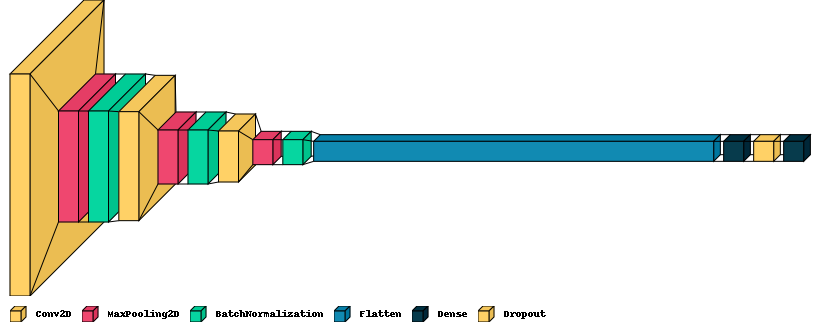

In [19]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(dr_model, scale_xy=1, legend=True)

In [20]:
dr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 8)      32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                        

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("DR_Model3_1.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False)
earlystop = EarlyStopping(monitor="val_acc",patience=7,verbose=1)

In [ ]:
steps_per_epoch = train_x.shape[0] // 64
validation_steps = valid_x.shape[0] // 32

dr_model.fit(train_x,train_y,steps_per_epoch = steps_per_epoch,validation_data = (valid_x,valid_y),validation_steps = validation_steps, epochs = 50,callbacks=[checkpoint,earlystop])

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 0.7374 - acc: 0.7561
Epoch 1: val_acc improved from -inf to 0.50626, saving model to DR_Model3_1.h5
40/40 [==============================] - 66s 2s/step - loss: 0.7374 - acc: 0.7561 - val_loss: 2.0243 - val_acc: 0.5063
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.5362 - acc: 0.8631
Epoch 2: val_acc improved from 0.50626 to 0.53242, saving model to DR_Model3_1.h5
40/40 [==============================] - 62s 2s/step - loss: 0.5362 - acc: 0.8631 - val_loss: 0.9183 - val_acc: 0.5324
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.4909 - acc: 0.8783
Epoch 3: val_acc improved from 0.53242 to 0.82139, saving model to DR_Model3_1.h5
40/40 [==============================] - 63s 2s/step - loss: 0.4909 - acc: 0.8783 - val_loss: 0.6236 - val_acc: 0.8214
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 0.4643 - acc: 0.8970
Epoch 4: val_acc improved from 0.82139 to 0.

In [15]:
from keras.models import Sequential,load_model
dr_model = load_model('DR_Model3_1.h5')

### 4. Resultados

In [16]:
dr_model.evaluate(valid_x,valid_y, verbose = 0)

[0.3349533677101135, 0.9522184133529663]

In [17]:
import numpy as np
valid_pred = np.argmax(dr_model.predict(valid_x),axis = 1)
valid_pred[0:10]

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1])

In [18]:
valid_y2 = np.array(pd.DataFrame(valid_y)[1])
valid_y2[0:10]

array([1., 0., 1., 0., 0., 0., 1., 1., 0., 1.], dtype=float32)

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

conf_mat=confusion_matrix(valid_y2,valid_pred)
TN=conf_mat[0,0]
FN=conf_mat[1,0]
TP=conf_mat[1,1]
FP=conf_mat[0,1]
sensitiviy=TP/(TP+FN)
specificity=TN/(TN+FP)
print('Conv Neural Net Result:')
print('----------------------------------')
print('Real/Predicted \n',conf_mat)
print('----------------------------------')
print('Sensitivity: \n',sensitiviy)
print('----------------------------------')
print('Specificity: \n',specificity)
print('----------------------------------')
print('Accuracy Score: \n',accuracy_score(valid_y2, valid_pred))
print('----------------------------------')
print('Classification Report: \n',classification_report(valid_y2, valid_pred))

Conv Neural Net Result:
----------------------------------
Real/Predicted 
 [[426  19]
 [ 23 411]]
----------------------------------
Sensitivity: 
 0.9470046082949308
----------------------------------
Specificity: 
 0.9573033707865168
----------------------------------
Accuracy Score: 
 0.9522184300341296
----------------------------------
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       445
         1.0       0.96      0.95      0.95       434

    accuracy                           0.95       879
   macro avg       0.95      0.95      0.95       879
weighted avg       0.95      0.95      0.95       879



El modelo obtuvo una exactitud en el conjunto de validación de 95%. Adicionalmente, las métricas de sensibilidad y especificidad son de 95% y 96% respectivamente. Esto indica que el modelo tiene una capacidad de predecir correctamente cuando un paciente efectivamente tiene la enfermedad de RD el 95% de las veces y una capacidad del 96% de predecir correctamente cuando no lo tiene (de acuerdo con el conjunto de validación). Para el caso en cuestión, mientras mayor sea la sensibilidad es mejor, puesto que el modelo se especializa en predecir correctamente la clase de interés, es decir, se especializa en predecir cuando el paciente tiene retinopatía diabética.


In [20]:
test_y2 = np.array(pd.DataFrame(test_y)[1])
test_y2[0:10]

array([1., 1., 0., 0., 1., 0., 0., 1., 1., 0.], dtype=float32)

In [21]:
test_pred = np.argmax(dr_model.predict(test_x),axis = 1)

conf_mat=confusion_matrix(test_y2,test_pred)
TN=conf_mat[0,0]
FN=conf_mat[1,0]
TP=conf_mat[1,1]
FP=conf_mat[0,1]
sensitiviy=TP/(TP+FN)
specificity=TN/(TN+FP)
print('Conv Neural Net Result:')
print('----------------------------------')
print('Real/Predicted \n',conf_mat)
print('----------------------------------')
print('Sensitivity: \n',sensitiviy)
print('----------------------------------')
print('Specificity: \n',specificity)
print('----------------------------------')
print('Accuracy Score: \n',accuracy_score(test_y2,test_pred))
print('----------------------------------')
print('Classification Report: \n',classification_report(test_y2,test_pred))

Conv Neural Net Result:
----------------------------------
Real/Predicted 
 [[102   2]
 [  7 109]]
----------------------------------
Sensitivity: 
 0.9396551724137931
----------------------------------
Specificity: 
 0.9807692307692307
----------------------------------
Accuracy Score: 
 0.9590909090909091
----------------------------------
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      0.98      0.96       104
         1.0       0.98      0.94      0.96       116

    accuracy                           0.96       220
   macro avg       0.96      0.96      0.96       220
weighted avg       0.96      0.96      0.96       220



La exactitud resultó ser 96%, la sensibilidad en este caso fue de 94% y la especificidad de 98%, resultados aún mejores que los del conjunto de validación.

### 5. Conclusiones

Se considera que los resultados obtenidos en el modelo seleccionado han sido satisfactorios en general y en comparación con las metodologías realizadas similares a este estudio. Los pasos a futuro para este estudio constan de contactar a médicos locales a los que les interesaría participar en una investigación o un posible convenio con el objetivo de disponer de más imágenes, realizar pre procesamiento y entrenar la red con aún más datos para poder implementar un algoritmo en clínicas mexicanas en primera instancia. 

Para lograr dicho objetivo será necesaria una capacidad de máquina mayor que soporte cientos de miles de imágenes y sea efectiva sin afectar demasiado los tiempos de ejecución de la red. En caso de que los resultados no sean satisfactorios, se procederá a robustecer la red como se estuvo haciendo en el presente estudio.
